Testing single FALQON layer for both Heron and Eagle Processors...

Testing Heron Processor

Testing Heron Topo1...
  Expected Fidelity: 0.904922
  Total Gate Count: 154
  Energy: -0.767453

Testing Heron Topo2...
  Expected Fidelity: 0.865394
  Total Gate Count: 210
  Energy: -0.767453

Testing Heron Topo3...
  Expected Fidelity: 0.918580
  Total Gate Count: 132
  Energy: -0.767453

Testing Heron Topo4...
  Expected Fidelity: 0.925739
  Total Gate Count: 123
  Energy: -0.767453

Testing Heron Topo5...
  Expected Fidelity: 0.925232
  Total Gate Count: 127
  Energy: -0.767453

Testing Eagle Processor

Testing Eagle Topo1...
  Expected Fidelity: 0.742181
  Total Gate Count: 228
  Energy: -0.767453

Testing Eagle Topo2...
  Expected Fidelity: 0.664809
  Total Gate Count: 296
  Energy: -0.767453

Testing Eagle Topo3...
  Expected Fidelity: 0.769866
  Total Gate Count: 208
  Energy: -0.767453

Testing Eagle Topo4...
  Expected Fidelity: 0.784181
  Total Gate Count: 198
  Energy: -0.767453



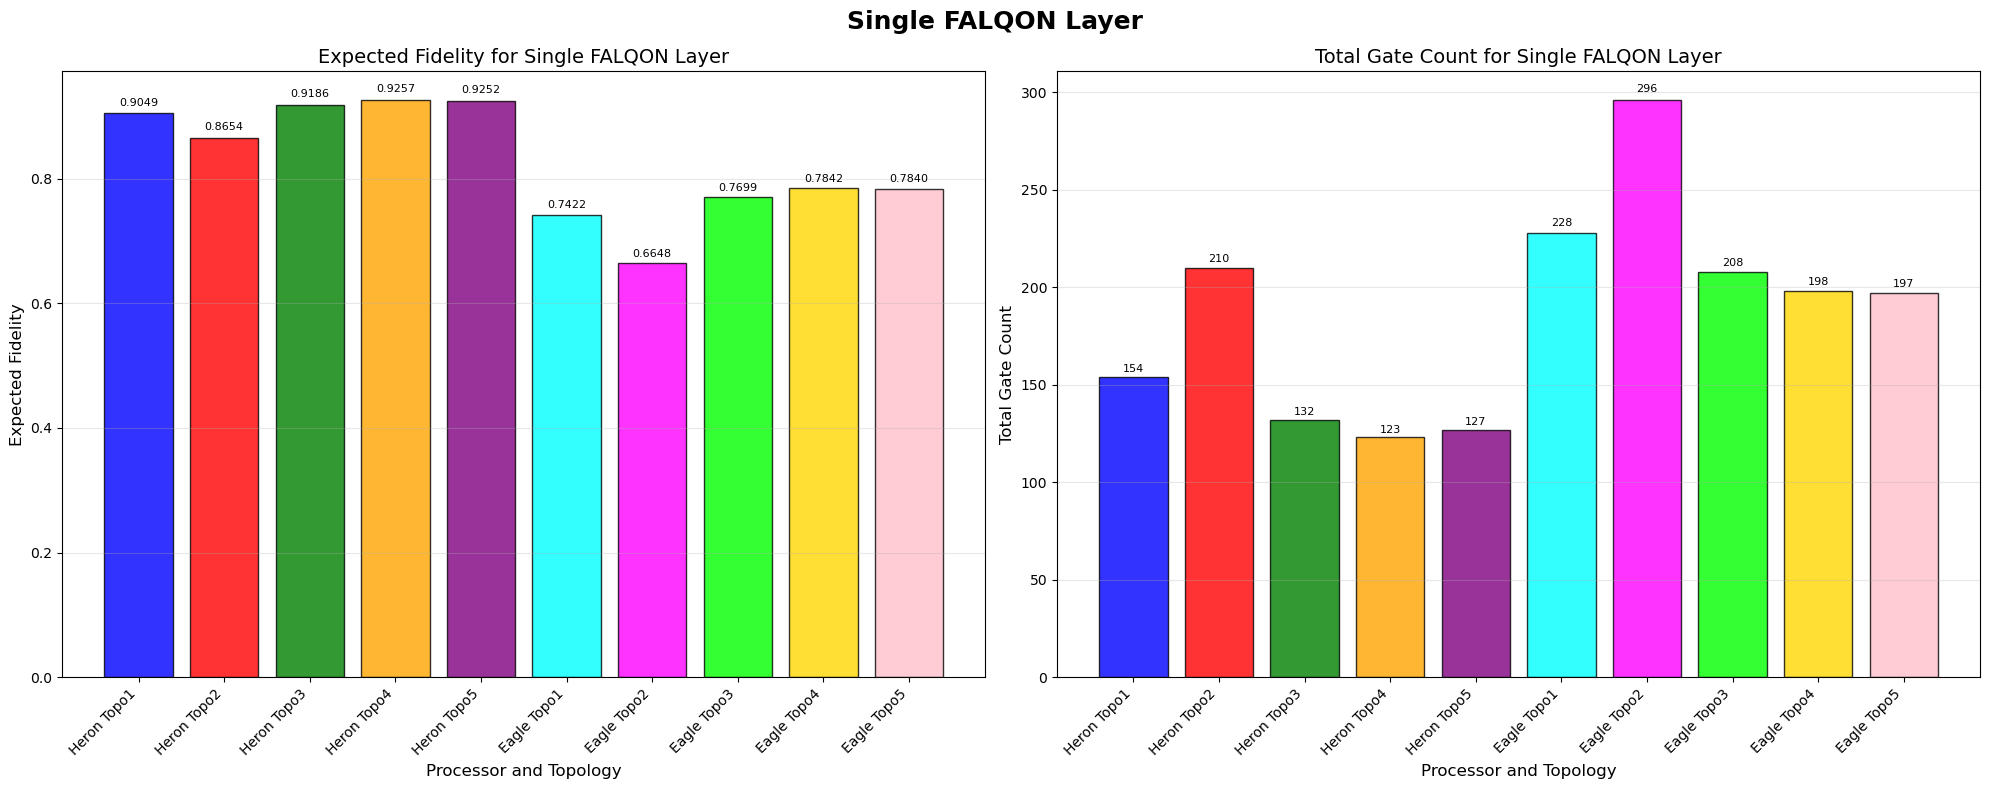


SINGLE FALQON LAYER - DETAILED RESULTS
Processor-Topology   Fidelity     Gate Count   Energy       Next Beta   
--------------------------------------------------------------------------------
Heron Topo1          0.904922     154          -0.767453    0.013478    
Heron Topo2          0.865394     210          -0.767453    0.013478    
Heron Topo3          0.918580     132          -0.767453    0.013478    
Heron Topo4          0.925739     123          -0.767453    0.013478    
Heron Topo5          0.925232     127          -0.767453    0.013478    
Eagle Topo1          0.742181     228          -0.767453    0.013478    
Eagle Topo2          0.664809     296          -0.767453    0.013478    
Eagle Topo3          0.769866     208          -0.767453    0.013478    
Eagle Topo4          0.784181     198          -0.767453    0.013478    
Eagle Topo5          0.784004     197          -0.767453    0.013478    

PERFORMANCE ANALYSIS
Highest Fidelity: Heron Topo4 with 0.925739
Lowest Gat

In [4]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np

# 通用设置
n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])

def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h = build_commutator(driver_h, cost_h)

def falqon_layer(qc, cost_h, driver_h, beta_k, delta_t):
    U_c = PauliEvolutionGate(cost_h, delta_t)
    U_d = PauliEvolutionGate(beta_k*driver_h, delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set = -1.13728383

def single_falqon_step(qc, cost_h, driver_h, comm_h, delta_t, beta_0):
    """运行单个FALQON步骤"""
    state = Statevector.from_label("+" * n_qubits)
    
    # 单个FALQON层
    qc_layer = QuantumCircuit(n_qubits)
    falqon_layer(qc_layer, cost_h, driver_h, beta_0, delta_t)
    qc.compose(qc_layer, inplace=True)
    state = state.evolve(qc_layer)
    
    # 计算能量和下一个beta
    energy = state.expectation_value(cost_h).real
    next_beta = -1 * state.expectation_value(comm_h).real
    
    return qc, energy, next_beta

def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    return qc

def calculate_expected_fidelity(gate_error, count_ops, readout_fidelity=1.0):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)
        fidelity *= (1 - error_rate) ** count
    fidelity *= readout_fidelity
    return fidelity

# 实验参数
beta_0 = 0.0
delta_t = 0.03

# 处理器配置
processors = {
    "Heron": {
        "basis_gates": ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x'],
        "gate_error": {
            "id": 2.738e-4,
            "rx": 2.738e-4,
            "rz": 0.0,
            "sx": 2.738e-4,
            "x": 2.738e-4,
            "cz": 1.947e-3,
            "rzz": 2.490e-3
        }
    },
    "Eagle": {
        "basis_gates": ['ecr', 'id', 'rz', 'sx', 'x'],
        "gate_error": {
            "ecr": 5.824e-3,      
            "id": 2.252e-4,      
            "rz": 0.0,           
            "sx": 2.252e-4,      
            "x": 2.252e-4,       
        }
    }
}

# 定义不同的拓扑结构
topologies = {
    "Topo1": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)],
    "Topo2": [(0, 1), (1, 0), (1, 2), (2, 1), (1, 3), (3, 1)],
    "Topo3": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)],
    "Topo4": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0), (0, 2), (2, 0)],
    "Topo5": [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (2, 0), (0, 2)]
}

# 存储所有结果
all_results = {}
labels = []

print("Testing single FALQON layer for both Heron and Eagle Processors...")

# 对每个处理器和每个拓扑运行实验
for processor_name, processor_config in processors.items():
    print(f"\n{'='*50}")
    print(f"Testing {processor_name} Processor")
    print(f"{'='*50}")
    
    basis_gates = processor_config["basis_gates"]
    gate_error = processor_config["gate_error"]
    
    for topo_name, coupling_list in topologies.items():
        combined_name = f"{processor_name} {topo_name}"
        labels.append(combined_name)
        print(f"\nTesting {combined_name}...")
        
        coupling_map = CouplingMap(couplinglist=coupling_list)
        
        # 初始化电路
        qc_initial = uniform_superposition_circuit()
        
        # 运行单个FALQON步骤
        final_circuit, energy, next_beta = single_falqon_step(
            qc=qc_initial,
            cost_h=cost_h,
            driver_h=driver_h,
            comm_h=comm_h,
            delta_t=delta_t,
            beta_0=beta_0
        )

        # Transpile 电路
        transpiled_circuit = transpile(
            final_circuit,
            basis_gates=basis_gates,
            coupling_map=coupling_map,
            optimization_level=1
        )

        # 统计 gate count
        gate_counts = transpiled_circuit.count_ops()
        total_count = sum(gate_counts.values())

        # 计算 expected fidelity
        expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
        
        # 存储结果
        all_results[combined_name] = {
            'fidelity': expected_fidelity,
            'gate_count': total_count,
            'energy': energy,
            'next_beta': next_beta,
            'processor': processor_name,
            'topology': topo_name
        }
        
        print(f"  Expected Fidelity: {expected_fidelity:.6f}")
        print(f"  Total Gate Count: {total_count}")
        print(f"  Energy: {energy:.6f}")

# 准备绘图数据
fidelities = [all_results[label]['fidelity'] for label in labels]
gate_counts = [all_results[label]['gate_count'] for label in labels]

# 定义颜色 - 10种不同颜色
colors = ['blue', 'red', 'green', 'orange', 'purple', 
          'cyan', 'magenta', 'lime', 'gold', 'pink']

# 创建柱状图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Single FALQON Layer', fontsize=18, fontweight='bold')

# 柱状图1: Expected Fidelity
bars1 = ax1.bar(range(len(labels)), fidelities, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_xlabel('Processor and Topology', fontsize=12)
ax1.set_ylabel('Expected Fidelity', fontsize=12)
ax1.set_title('Expected Fidelity for Single FALQON Layer', fontsize=14)
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, fidelity) in enumerate(zip(bars1, fidelities)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{fidelity:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

# 柱状图2: Total Gate Count
bars2 = ax2.bar(range(len(labels)), gate_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Processor and Topology', fontsize=12)
ax2.set_ylabel('Total Gate Count', fontsize=12)
ax2.set_title('Total Gate Count for Single FALQON Layer', fontsize=14)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 在柱子上方添加数值标签
for i, (bar, count) in enumerate(zip(bars2, gate_counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.show()

# 打印详细统计
print("\n" + "="*80)
print("SINGLE FALQON LAYER - DETAILED RESULTS")
print("="*80)

print(f"{'Processor-Topology':<20} {'Fidelity':<12} {'Gate Count':<12} {'Energy':<12} {'Next Beta':<12}")
print("-" * 80)

for label in labels:
    result = all_results[label]
    print(f"{label:<20} {result['fidelity']:<12.6f} {result['gate_count']:<12} {result['energy']:<12.6f} {result['next_beta']:<12.6f}")

# 找出最佳性能
print(f"\n{'='*80}")
print("PERFORMANCE ANALYSIS")
print("="*80)

best_fidelity = max(all_results.items(), key=lambda x: x[1]['fidelity'])
best_gate_count = min(all_results.items(), key=lambda x: x[1]['gate_count'])

print(f"Highest Fidelity: {best_fidelity[0]} with {best_fidelity[1]['fidelity']:.6f}")
print(f"Lowest Gate Count: {best_gate_count[0]} with {best_gate_count[1]['gate_count']} gates")

# 按处理器分组统计
print(f"\nHERON PROCESSOR AVERAGE:")
heron_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Heron']
heron_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Heron']
print(f"  Average Fidelity: {np.mean(heron_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(heron_gates):.1f}")

print(f"\nEAGLE PROCESSOR AVERAGE:")
eagle_fidelities = [result['fidelity'] for label, result in all_results.items() if result['processor'] == 'Eagle']
eagle_gates = [result['gate_count'] for label, result in all_results.items() if result['processor'] == 'Eagle']
print(f"  Average Fidelity: {np.mean(eagle_fidelities):.6f}")
print(f"  Average Gate Count: {np.mean(eagle_gates):.1f}")